## Data exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
df = pd.read_csv('dataset1.csv')
print(df.head())
 
cols_to_plot = ["Ozone","Nitrogen Oxide","PM10","PM2.5"]

i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

      Ozone  Nitrogen Oxide  PM2.5   PM10
0   5.89367        67.80391  3.526  6.016
1   6.48827        68.10326  3.315  5.912
2   7.13705        68.70197  3.117  5.421
3   7.46188        68.55230  3.059  5.113
4  10.32605        63.26369  3.339  5.309


<Figure size 1000x1200 with 4 Axes>

## Preprocessing - there are many other ways

In [7]:
df.fillna(0, inplace = True)

df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

#print(df_test)
X_train = df_train.loc[:, ["Ozone","Nitrogen Oxide","PM2.5"]].values.copy()
X_test = df_test.loc[:, ["Ozone","Nitrogen Oxide","PM2.5"]].values.copy()

y_train = df_train['PM2.5'].values.copy().reshape(-1, 1)
y_test = df_test['PM2.5'].values.copy().reshape(-1, 1)
 


## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [9]:
input_seq_len = 3
output_seq_len = 2

def generate_train_samples(x = X_train, y = y_train, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)

def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [10]:
x, y = generate_train_samples()
print(x, y)

[[[  0.        2.72746  72.364  ]
  [ 59.5247    2.52789  61.748  ]
  [ 33.1473   51.68863   3.765  ]]

 [[ 22.4597   24.41406  11.25   ]
  [ 44.68231  11.1094    9.111  ]
  [ 13.076    28.98754   2.827  ]]

 [[ 18.07313  75.58714   5.383  ]
  [ 13.96125  78.58069   5.782  ]
  [ 11.23594  80.72607   5.581  ]]

 [[ 16.52591 156.3132   13.363  ]
  [ 20.66839 130.06975  12.009  ]
  [ 24.42263  94.99532   9.678  ]]

 [[ 26.60001  44.45422   9.903  ]
  [ 42.02738  17.36259  11.889  ]
  [ 40.03599   7.08474  13.05   ]]

 [[ 60.24375  32.28045  34.946  ]
  [ 63.495    30.78367  49.031  ]
  [ 56.9925   27.49077  14.745  ]]

 [[ 16.60791   0.        3.807  ]
  [ 12.01962   0.        3.066  ]
  [ 12.34878   0.        1.768  ]]

 [[ 17.5731   61.71702   4.776  ]
  [ 19.92825  52.03788   4.744  ]
  [ 25.57615  47.84691   4.771  ]]

 [[ 13.57875  34.82497  22.828  ]
  [ 12.6225   38.91615  22.649  ]
  [ 19.79438  30.08518  23.354  ]]

 [[ 39.3975   11.9742    8.578  ]
  [ 36.76781   5.83742   7.082

In [6]:
test_x, test_y = generate_test_samples()
print(test_x.shape, test_y.shape)

((709, 30, 4), (709, 5, 1))


## Building the model - same multi-variate graph

## Train the model 

In [7]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import tensorflow as tf
import copy
import os

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = X_train.shape[1]
# num of output signals
output_dim = y_train.shape[1]
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
total_iteractions = 300
batch_size = 16
KEEP_RATE = 0.4
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)

Training losses: 
626.3995
304.28845
117.25295
1942.6836
635.8685
293.376
182.7243
446.466
130.56937
76.75253
196.92525
242.03285
424.68173
175.77142
781.4211
87.497284
114.63929
106.01935
185.79404
107.2236
46.031216
50.809223
50.767105
127.39093
31.173157
83.94215
182.99408
227.96002
61.908257
101.31522
43.81657
22.175241
154.0951
30.916859
52.77058
27.78137
115.582054
68.18522
89.19018
67.56173
64.479904
36.73544
50.311325
175.28966
396.6644
105.670425
53.675446
57.30841
93.93699
29.464724
50.199253
60.057255
37.429527
84.4693
58.20602
88.963615
94.34387
143.12799
45.997326
40.814354
31.49454
45.713467
59.53921
64.6325
258.57657
47.225815
22.7916
159.96407
88.37387
52.612556
98.807396
236.8277
40.821495
118.64901
123.267624
71.69826
50.47014
49.473972
282.62546
38.20865
465.6431
115.80146
120.29789
128.68433
27.492163
23.6633
34.18352
42.036694
14.314926
91.720505
290.06033
128.29962
83.68463
92.59598
59.874138
144.35379
153.94225
102.374466
76.87405
44.52207
104.95088
55.93038
174.

## Inference on test 
Notice the batch prediction which is different to previous

In [9]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    saver = rnn_model['saver']().restore(sess,  os.path.join('./', 'multivariate_ts_pollution_case'))
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./multivariate_ts_pollution_case
('Test mse is: ', 15.605034419164173)


In [10]:
## remove duplicate hours and concatenate into one long array
test_y_expand = np.concatenate([test_y[i].reshape(-1) for i in range(0, test_y.shape[0], 5)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i].reshape(-1) for i in range(0, final_preds.shape[0], 5)], axis = 0)

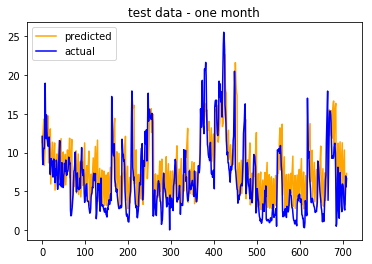

[[[12.083]
  [ 9.144]
  [ 8.434]
  [10.304]
  [10.533]]

 [[ 9.144]
  [ 8.434]
  [10.304]
  [10.533]
  [10.533]]

 [[ 8.434]
  [10.304]
  [10.533]
  [10.533]
  [13.731]]

 ...

 [[ 4.152]
  [ 6.968]
  [ 5.56 ]
  [ 6.634]
  [ 2.6  ]]

 [[ 6.968]
  [ 5.56 ]
  [ 6.634]
  [ 2.6  ]
  [ 2.1  ]]

 [[ 5.56 ]
  [ 6.634]
  [ 2.6  ]
  [ 2.1  ]
  [ 1.55 ]]]
[[[11.303355 ]
  [11.970403 ]
  [12.590906 ]
  [13.5501175]
  [14.319049 ]]

 [[ 9.770045 ]
  [10.836939 ]
  [11.908345 ]
  [13.187985 ]
  [14.107871 ]]

 [[ 6.346345 ]
  [ 7.5755267]
  [ 8.763384 ]
  [10.225182 ]
  [11.519854 ]]

 ...

 [[ 3.1979067]
  [ 4.3476253]
  [ 5.311998 ]
  [ 6.3183136]
  [ 7.3595767]]

 [[ 3.570648 ]
  [ 4.6989794]
  [ 5.704909 ]
  [ 6.767458 ]
  [ 7.873914 ]]

 [[ 6.4628024]
  [ 7.948054 ]
  [ 9.265683 ]
  [10.678805 ]
  [11.918126 ]]]


In [11]:
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()
print(test_y)
print(final_preds)